In [64]:
import pandas as pd
import numpy as np
import cuml
import cudf
import cupy as cp
import dask_cudf
import sys
import os
import dask
from pprint import pprint
import warnings
import random 
import dask.dataframe as dd
import matplotlib.pyplot as plt
from matplotlib.pyplot import ylim, xlim
from matplotlib.colors import ListedColormap
import datashader as ds
import datashader.transfer_functions as tf
import panel as pn
from cuml.decomposition import PCA as PCA_GPU
from sklearn.decomposition import PCA
from dask_ml.xgboost import XGBClassifier
from dask_ml.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import sklearn; print('Scikit-Learn Version:', sklearn.__version__)
import xgboost as xgb; print('XGBoost Version:', xgb.__version__)

warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'dask_ml'

In [2]:
df = cudf.read_csv('./Partical.csv')

In [3]:
print('data',df.shape)

data (10999999, 29)


In [4]:
df.columns = ['Class', 'lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']

In [5]:
df

,Class,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,...,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0.0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,...,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10999994,1.0,1.159912,1.013847,0.108615,1.495524,-0.537545,2.342396,-0.839740,1.320683,0.000000,...,-0.097068,1.190680,3.101961,0.822136,0.766772,1.002191,1.061233,0.837004,0.860472,0.772484
10999995,1.0,0.618388,-1.012982,1.110139,0.941023,-0.379199,1.004656,0.348535,-1.678593,2.173076,...,-0.216995,1.049177,3.101961,0.826829,0.989809,1.029104,1.199679,0.891481,0.938490,0.865269
10999996,1.0,0.700559,0.774251,1.520182,0.847112,0.211230,1.095531,0.052457,0.024553,2.173076,...,1.585235,1.713962,0.000000,0.337374,0.845208,0.987610,0.883422,1.888438,1.153766,0.931279
10999997,0.0,1.178030,0.117796,-1.276980,1.864457,-0.584370,0.998519,-1.264549,1.276333,0.000000,...,1.399515,-1.313189,0.000000,0.838842,0.882890,1.201380,0.939216,0.339705,0.759070,0.719119


In [6]:
pandas_df = df.to_pandas()
X = pandas_df.drop('Class',axis= 1)
Y = pandas_df['Class']

In [7]:
df.isna().sum()

Class                       0
lepton pT                   0
lepton eta                  0
lepton phi                  0
missing energy magnitude    0
missing energy phi          0
jet 1 pt                    0
jet 1 eta                   0
jet 1 phi                   0
jet 1 b-tag                 0
jet 2 pt                    0
jet 2 eta                   0
jet 2 phi                   0
jet 2 b-tag                 0
jet 3 pt                    0
jet 3 eta                   0
jet 3 phi                   0
jet 3 b-tag                 0
jet 4 pt                    0
jet 4 eta                   0
jet 4 phi                   0
jet 4 b-tag                 0
m_jj                        0
m_jjj                       0
m_lv                        0
m_jlv                       0
m_bb                        0
m_wbb                       0
m_wwbb                      0
dtype: uint64

In [8]:
df.dtypes

Class                       float64
lepton pT                   float64
lepton eta                  float64
lepton phi                  float64
missing energy magnitude    float64
missing energy phi          float64
jet 1 pt                    float64
jet 1 eta                   float64
jet 1 phi                   float64
jet 1 b-tag                 float64
jet 2 pt                    float64
jet 2 eta                   float64
jet 2 phi                   float64
jet 2 b-tag                 float64
jet 3 pt                    float64
jet 3 eta                   float64
jet 3 phi                   float64
jet 3 b-tag                 float64
jet 4 pt                    float64
jet 4 eta                   float64
jet 4 phi                   float64
jet 4 b-tag                 float64
m_jj                        float64
m_jjj                       float64
m_lv                        float64
m_jlv                       float64
m_bb                        float64
m_wbb                       

In [9]:
df['Class'].value_counts()

1.0    5829122
0.0    5170877
Name: Class, dtype: int32

<AxesSubplot:title={'center':'Correlation of Features to Class'}>

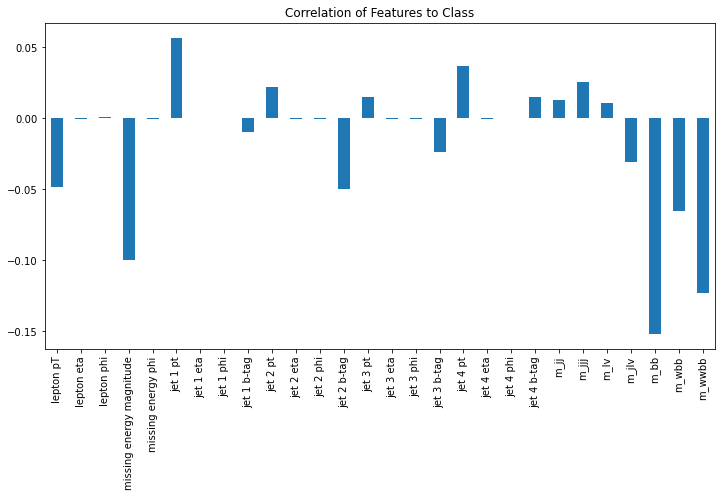

In [10]:
X.corrwith(Y).plot(kind='bar', figsize=(12, 6), title='Correlation of Features to Class')

In [11]:
correlation = pandas_df.corr()
print(correlation)

                             Class  lepton pT  lepton eta  lepton phi  \
Class                     1.000000  -0.048599   -0.000134    0.000643   
lepton pT                -0.048599   1.000000   -0.000153   -0.000175   
lepton eta               -0.000134  -0.000153    1.000000    0.000418   
lepton phi                0.000643  -0.000175    0.000418    1.000000   
missing energy magnitude -0.099999  -0.139528   -0.000438   -0.000012   
missing energy phi       -0.000539   0.000232    0.000161   -0.044518   
jet 1 pt                  0.056908   0.165798   -0.000396   -0.000135   
jet 1 eta                -0.000003  -0.000135    0.264797    0.000793   
jet 1 phi                 0.000431  -0.000335   -0.000187   -0.167880   
jet 1 b-tag              -0.009731  -0.006265    0.000275   -0.000178   
jet 2 pt                  0.021891   0.004612    0.000123   -0.000241   
jet 2 eta                -0.000183   0.000031    0.264615    0.000419   
jet 2 phi                -0.000734   0.000071   -0.

In [12]:
#standardization of Data
sc = StandardScaler()
df_X_std = pd.DataFrame(sc.fit_transform(X), columns=X.columns)
cudf_X_std = cudf.DataFrame.from_pandas(df_X_std)

In [13]:
# Perform PCA with 2 components for visualization
pca = PCA_GPU(n_components=2)
cudf_pca = pca.fit_transform(cudf_X_std)

In [14]:
cudf_pca

,0,1
0,-1.166905,1.159709
1,-0.580045,-2.579282
2,1.395165,2.371679
3,-0.881612,0.166825
4,-0.884473,1.014041
...,...,...
10999994,0.644566,-0.849966
10999995,-0.410717,0.468686
10999996,0.236961,-2.077051
10999997,-1.326158,-0.098825


In [15]:
PCA_pd = cudf_pca.to_pandas()
fins = PCA_pd.join([Y])
fins.columns = [ 'PCA1', 'PCA2', 'Class']
fins

,PCA1,PCA2,Class
0,-1.166905,1.159709,1.0
1,-0.580045,-2.579282,1.0
2,1.395165,2.371679,0.0
3,-0.881612,0.166825,1.0
4,-0.884473,1.014041,0.0
...,...,...,...
10999994,0.644566,-0.849966,1.0
10999995,-0.410717,0.468686,1.0
10999996,0.236961,-2.077051,1.0
10999997,-1.326158,-0.098825,0.0


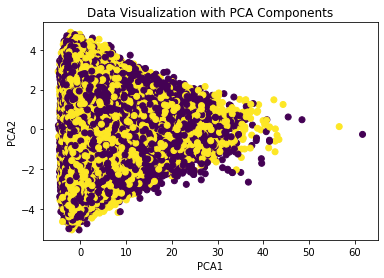

In [16]:
# Visualize data with PCA components using matplotlib
df_pca = cudf.DataFrame.from_pandas(fins)
plt.scatter(df_pca['PCA1'].to_array(), df_pca['PCA2'].to_array(), c=df_pca['Class'].to_array(), cmap='viridis')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Data Visualization with PCA Components')
plt.show()

In [17]:
# Detect outliers using IQR on PCA components
pca_components = df_pca.drop('Class', axis=1)
q1 = pca_components.quantile(0.25)
q3 = pca_components.quantile(0.75)
iqr = q3 - q1
iqr_multiplier = 1.5
lower_bound = q1 - iqr_multiplier * iqr
upper_bound = q3 + iqr_multiplier * iqr
outliers = (pca_components < lower_bound) | (pca_components > upper_bound)
outliers = outliers.any(axis=1)

In [18]:
# Remove outliers from the original cudf DataFrame
df_rmv_outliers = cudf_X_std[~outliers]

In [19]:
df_cleaned_pca = pca.transform(df_rmv_outliers)

In [20]:
new_pd = df_cleaned_pca.to_pandas()
new_df = new_pd.join([Y])
new_df.columns = [ 'PCA1', 'PCA2', 'Class']
new_df

,PCA1,PCA2,Class
0,-1.166905,1.159709,1.0
1,-0.580045,-2.579282,1.0
2,1.395165,2.371679,0.0
3,-0.881612,0.166825,1.0
4,-0.884473,1.014041,0.0
...,...,...,...
10999994,0.644566,-0.849966,1.0
10999995,-0.410717,0.468686,1.0
10999996,0.236961,-2.077051,1.0
10999997,-1.326158,-0.098825,0.0


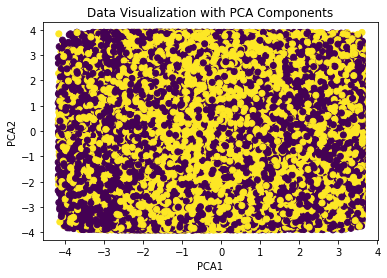

In [21]:
# Visualize data with PCA components using matplotlib
nwdf_pca = cudf.DataFrame.from_pandas(new_df)
plt.scatter(nwdf_pca['PCA1'].to_array(), nwdf_pca['PCA2'].to_array(), c=nwdf_pca['Class'].to_array(), cmap='viridis')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Data Visualization with PCA Components')
plt.show()

In [22]:
df_prcd = df[~outliers]

In [23]:
data_skew = df_prcd.skew()

# Print the skewness values
print(data_skew)

Class                      -0.138847
lepton pT                   1.545672
lepton eta                  0.000008
lepton phi                  0.000528
missing energy magnitude    1.201846
missing energy phi         -0.000671
jet 1 pt                    1.551638
jet 1 eta                   0.000170
jet 1 phi                  -0.000372
jet 1 b-tag                 0.152093
jet 2 pt                    1.431892
jet 2 eta                   0.000732
jet 2 phi                   0.000079
jet 2 b-tag                 0.207922
jet 3 pt                    1.319071
jet 3 eta                  -0.000557
jet 3 phi                   0.000695
jet 3 b-tag                 0.449414
jet 4 pt                    1.530568
jet 4 eta                  -0.000155
jet 4 phi                   0.000224
jet 4 b-tag                 0.759343
m_jj                        2.936587
m_jjj                       1.607984
m_lv                        4.193110
m_jlv                       1.542230
m_bb                        1.258763
m

In [25]:
variables_to_transform = ['lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi',
                          'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi',
                          'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta',
                          'jet 4 phi', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']

# Iterate over variables and check skewness, apply log transformation if necessary
for variable in variables_to_transform:
    skewness = df_prcd[variable].skew()
    if skewness > 1:
        df_prcd[variable] = np.log(df_prcd[variable])

In [26]:
data_skew = df_prcd.skew()

# Print the skewness values
print(data_skew)

Class                      -0.138847
lepton pT                   0.117607
lepton eta                  0.000008
lepton phi                  0.000528
missing energy magnitude   -0.937208
missing energy phi         -0.000671
jet 1 pt                   -0.004334
jet 1 eta                   0.000170
jet 1 phi                  -0.000372
jet 1 b-tag                 0.152093
jet 2 pt                   -0.071465
jet 2 eta                   0.000732
jet 2 phi                   0.000079
jet 2 b-tag                 0.207922
jet 3 pt                   -0.060861
jet 3 eta                  -0.000557
jet 3 phi                   0.000695
jet 3 b-tag                 0.449414
jet 4 pt                    0.234476
jet 4 eta                  -0.000155
jet 4 phi                   0.000224
jet 4 b-tag                 0.759343
m_jj                        0.292608
m_jjj                       0.427708
m_lv                        2.796979
m_jlv                       0.464053
m_bb                       -0.603579
m

In [30]:
from cuml.model_selection import train_test_split

In [32]:
X_train, X_validation, y_train, y_validation = cuml.model_selection.train_test_split(df_prcd, 'Class', train_size=.9)

In [41]:
print('dimensions of training split: ', X_train.shape)

dimensions of training split:  (9368188, 28)


In [35]:
%%time

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalidation = xgb.DMatrix(X_validation, label=y_validation)

CPU times: user 104 ms, sys: 44.6 ms, total: 149 ms
Wall time: 213 ms


In [49]:
# instantiate params
params = {}

# general params
general_params = {'silent': 1}
params.update(general_params)

# booster params
n_gpus = 1  # change this to -1 to use all GPUs available or 0 to use the CPU
booster_params = {}

if n_gpus != 0:
    booster_params['tree_method'] = 'gpu_hist'
    booster_params['n_gpus'] = n_gpus   
params.update(booster_params)

# learning task params
learning_task_params = {}
learning_task_params['eval_metric'] = 'auc'
learning_task_params['objective'] = 'binary:logistic'
params.update(learning_task_params)
print(params)

{'silent': 1, 'tree_method': 'gpu_hist', 'n_gpus': 1, 'eval_metric': 'auc', 'objective': 'binary:logistic'}


In [50]:
# model training settings
evallist = [(dvalidation, 'validation'), (dtrain, 'train')]
num_round = 100

In [51]:
%%time

bst = xgb.train(params, dtrain, num_round, evallist)

[01:15:04] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:576: 
Parameters: { "n_gpus", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.74183	train-auc:0.74285
[1]	validation-auc:0.75308	train-auc:0.75379
[2]	validation-auc:0.76172	train-auc:0.76266
[3]	validation-auc:0.76757	train-auc:0.76843
[4]	validation-auc:0.77311	train-auc:0.77402
[5]	validation-auc:0.77704	train-auc:0.77795
[6]	validation-auc:0.78165	train-auc:0.78252
[7]	validation-auc:0.78531	train-auc:0.78610
[8]	validation-auc:0.78789	train-auc:0.78860
[9]	validation-auc:0.78968	train-auc:0.79041
[10]	validation-auc:0.79160	train-auc:0.79231
[11]	validation-auc:0.79353	train-auc:0.79420
[12]	validation-auc:0.79483	train-

In [60]:
df_dd = dd.read_csv('Partical.csv')

In [63]:
df_dd.x.sum().compute()

AttributeError: 'DataFrame' object has no attribute 'x'

In [62]:
from dask_ml.xgboost import XGBRegressor

ModuleNotFoundError: No module named 'dask_ml'

the confusion matrix, sensitivity, specificity, loss and AUC values to determine the
performance of the trained models.
? Show the benchmark performance for both CPU and GPU training cycles.

In [ ]:
# Encoding the target, which is categorical in nature
le = preprocessing.LabelEncoder()
training['Class'] = le.fit_transform(training['Class'])
training.head()